In [87]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline
import geopandas as gpd
import xarray as xr
import matplotlib.dates as mdates

# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, TIModel, BASENAMES, process_era5_daily_data
from MBsandbox.help_func import compute_stat, minimize_bias_geodetic, optimize_std_quot_brentq_geod

from oggm.utils import (floatyear_to_date, date_to_floatyear)

In [24]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True

# this needs to be changed if working on another computer
working_dir = utils.gettempdir(dirname='W5E5_quality', reset=True)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
# My configs
cfg.PARAMS['hydro_month_nh'] = 1
climate='W5E5'

2022-11-27 15:51:26: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-11-27 15:51:26: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-11-27 15:51:26: oggm.cfg: Multiprocessing: using all available processors (N=16)
2022-11-27 15:51:26: oggm.cfg: Multiprocessing switched ON after user settings.
2022-11-27 15:51:26: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.


In [25]:
fr = utils.get_rgi_region_file(14, version='62')
gdf = gpd.read_file(fr)

In [31]:
df = ['RGI60-14.12678']
# df = gdf.RGIId[:10]
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
gdir_leh = gdirs[0]

2022-11-27 15:53:11: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2022-11-27 15:53:11: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


2022-11-27 15:56:37: MBsandbox.mbmod_daily_oneflowline: (RGI60-14.12678) process_w5e5_data


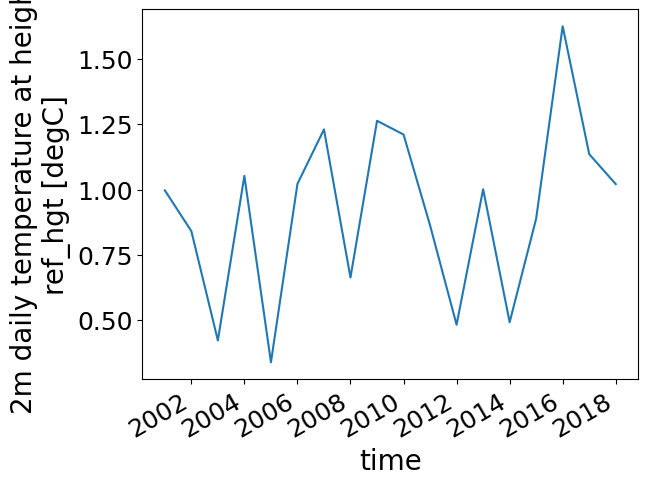

In [42]:
# Get climate Data
process_w5e5_data(gdir_leh, climate_type=climate, temporal_resol='daily', y0 = 2000)
file = gdir_leh.get_filepath("climate_historical", filesuffix="_daily_W5E5")
ds = xr.open_dataset(file)
# Data is in hydrological years
# -> let's just ignore the first and last calendar years
ds.temp.resample(time='AS').mean()[1:-1].plot();

In [48]:
ds

<xarray.Dataset>
Dimensions:   (time: 7305)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2019-12-31
Data variables:
    prcp      (time) float32 ...
    temp      (time) float32 ...
    gradient  (time) float32 ...
Attributes:
    ref_hgt:         4572.0
    ref_pix_lon:     77.75
    ref_pix_lat:     34.25
    ref_pix_dis:     18650.087280591542
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    hydro_yr_0:      2000
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model

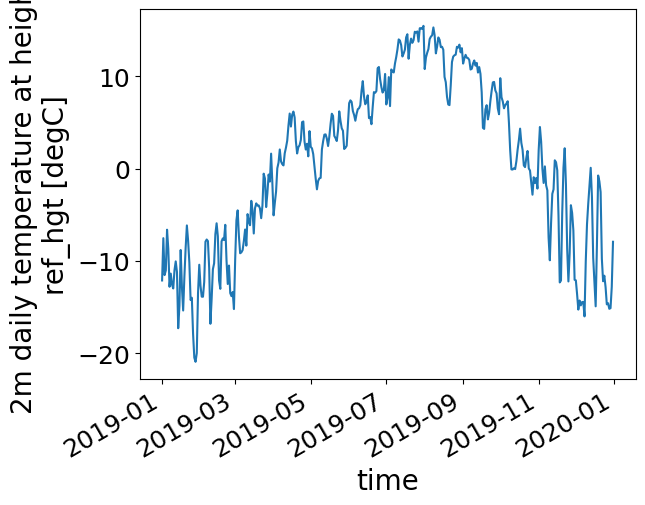

In [50]:
ds.sel(time='2019').temp.plot()

In [97]:
df = ds.sel(time='2019').temp.to_dataframe()
df = df.reset_index()

In [98]:
df1 = pd.read_csv(
            "/home/bsurya/work/air_model/data/gangles21/interim/field.csv",
            sep=",",
            parse_dates=["time"],
        )
df1 = df1.set_index("time")
lapse_rate = -0.0055
df1.temp += (4572 - 4009) * lapse_rate 
df1 = df1['temp'].resample('D').mean()
df1 = df1.reset_index()
df1["time"] = pd.to_datetime(df1["time"])
df["time"] = pd.to_datetime(df["time"])


[]

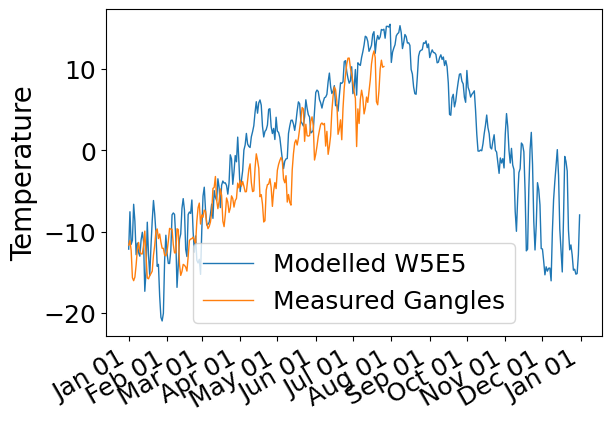

In [103]:
    fig, ax = plt.subplots()
    x1 = df.time
    x2 = df1.time
    y1 = df.temp
    y2 = df1.temp
    ax.set_ylabel("Temperature")
    ax.plot(
#        x1,
        y1,
        label="Modelled W5E5",
        linewidth=1
    )
    ax.plot(
#        x2,
        y2,
        label="Measured Gangles",
        linewidth=1
    )
    plt.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
#    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    fig.autofmt_xdate()
    plt.savefig(
        "W5E5_Validation.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.plot()
